In [1]:
# 推測統計のためのライブラリ、データ準備
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, integrate
from scipy.optimize import minimize_scalar

%precision 3
%matplotlib inline

In [3]:
# 期待値、分散などをあらかじめ定義しておく
linestyles = ['-', '--', ':']

def E(X,  g=lambda x: x):
    x_range, f = X
    def integrand(x):
        return g(x) * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def V(X, g=lambda x: x):
    x_range, f = X
    mean = E(X, g)
    def integrand(x):
        return (g(x) - mean) ** 2 * f(x)
    return integrate.quad(integrand, -np.inf, np.inf)[0]

def check_prob(X):
    x_range, f = X
    f_min = minimize_scalar(f).fun
    assert f_min >= 0, '密度関数が負の値をとります'
    prob_sum = np.round(integrate.quad(f, -np.inf, np.inf)[0], 6)
    assert prob_sum == 1, f'確率の和が{prob_sum}になりました'
    print(f'期待値は{E(X): .3f}')
    print(f'分散は{V(X): .3f}')
    
def plot_prob(X, x_min, x_max):
    x_range, f = X
    def F(x):
        return integrate.quad(f, -np.inf, x)[0]
    
    xs = np.linspace(x_min, x_max, 100)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(xs, [f(x) for x in xs],
                   label='f(x)', color='gray')
    ax.plot(xs, [F(x) for x in xs],
                   label='F(x)', ls='--', color='gray')
    
    axd.legend()
    plt.show()

In [4]:
# 正規分布の実装(Numpy)
#  平均値を中心にして分布が左右均等
def N(mu, sigma):
    x_range = [-np.inf, np.inf]
    def f(x):
        return 1 / np.sqrt(2 * np.pi * sigma**2) *\
                            np.exp(-(x-mu)**2 / (2 * sigma**2))
    return x_range, f

In [5]:
#N(2, 0.5^2)に従う確率変数Xを作成
mu, sigma = 2, 0.5
X = N(mu, sigma)

In [6]:
check_prob(X)

期待値は 2.000
分散は 0.250


NameError: name 'axd' is not defined

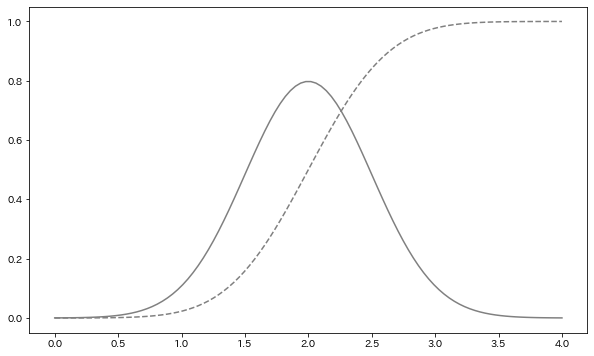

In [8]:
# 密度関数と分布関数を0から4の区間で図示
plot_prob(X, 0, 4)